In [103]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [36]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [37]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [38]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


In [39]:
df['Churn Label'].value_counts(normalize=True)*100

Churn Label
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

26% of passengers churned from purchasing

# Background

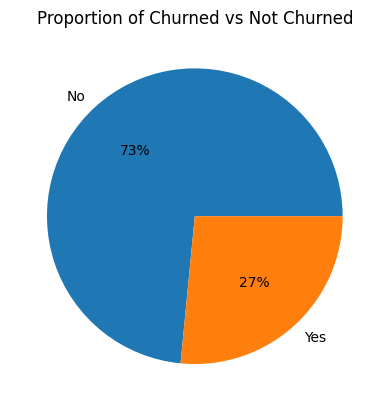

In [40]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

26% of passengers churned from purchasing

In [41]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future will be gone.

Around `Rp180,870,800.00` strip out from the company's monthly income.

# EDA

## Distribution

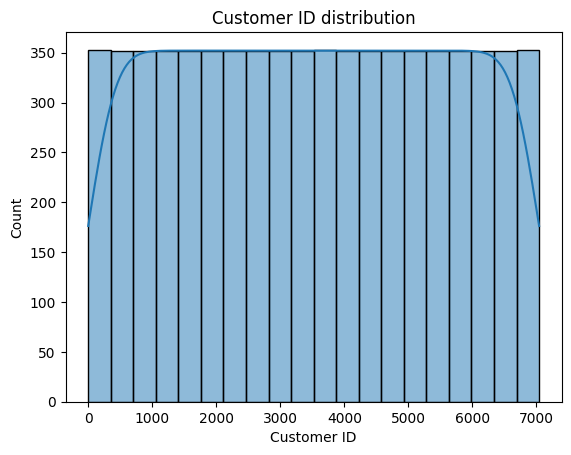

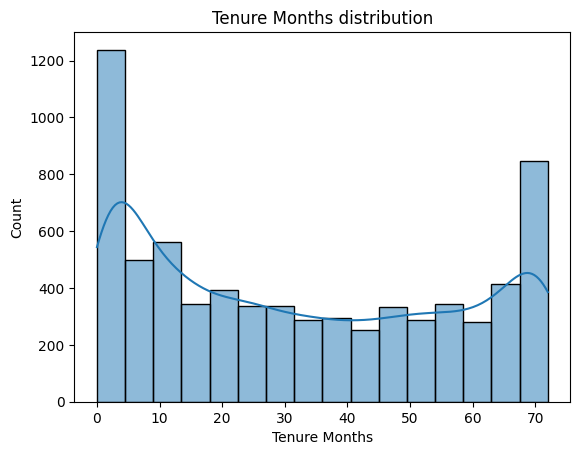

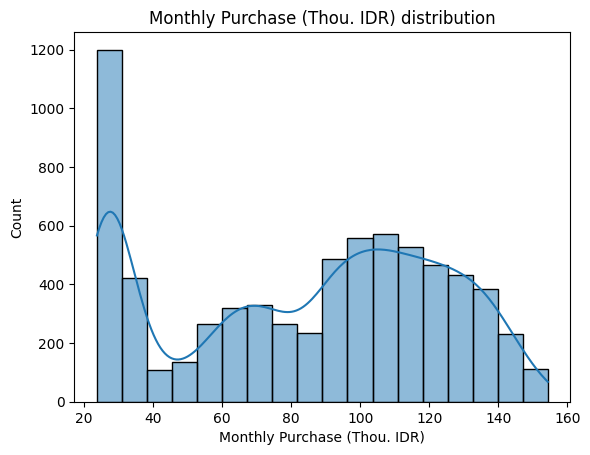

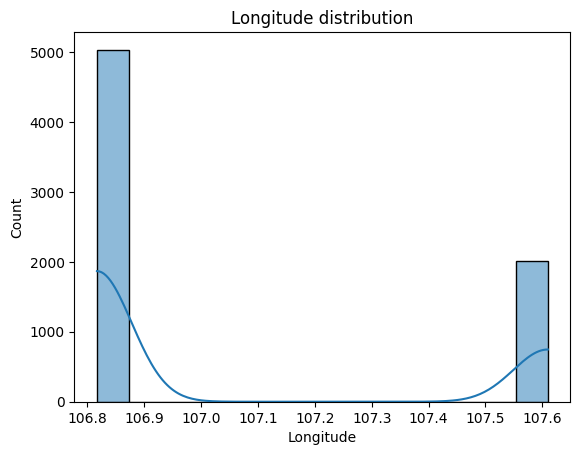

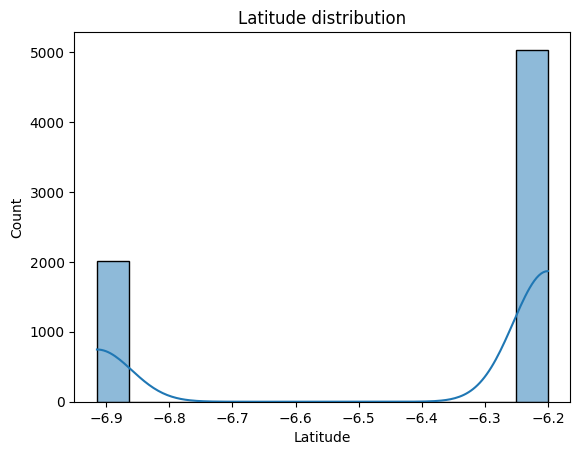

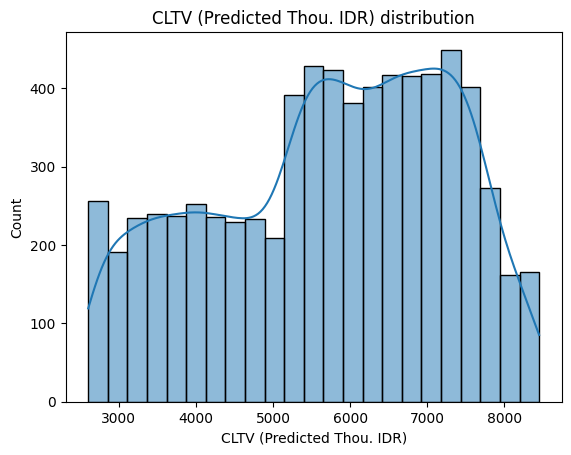

In [42]:
for c in df.select_dtypes(include=[int, float]):
    sns.histplot(df[c], kde=True)
    plt.title(f"{c} distribution")
    plt.show()

## Device Class

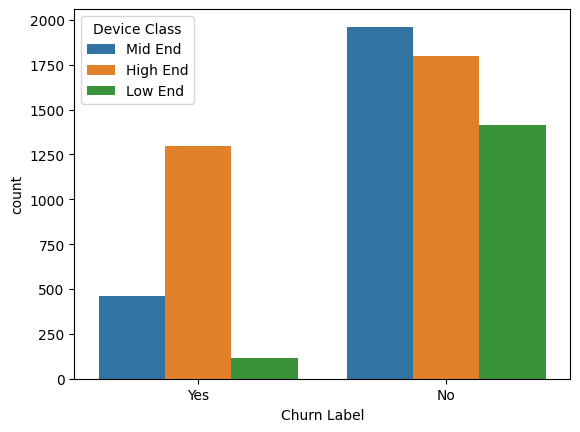

In [6]:
sns.countplot(data=df, x='Churn Label', hue='Device Class')
plt.show()

`~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn

In [7]:
churn_device = df.pivot_table(columns="Device Class", index='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Device Class,High End,Low End,Mid End
Churn Label,,,
No,0.581072,0.92595,0.810409
Yes,0.418928,0.07405,0.189591


high end class users have 40% change of churning, 18% are mid end class users, and 7% are from low end class users

## Location

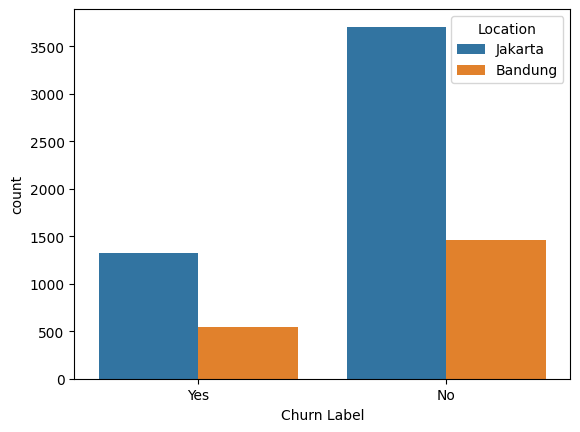

In [8]:
sns.countplot(data=df, x='Churn Label', hue='Location')
plt.show()

`Monthly Purchase (Thou. IDR)` doesn't influence the Churn of customers.

In [9]:
churn_device = df.pivot_table(columns="Location", index='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Location,Bandung,Jakarta
Churn Label,,
No,0.728628,0.73703
Yes,0.271372,0.26297


But I think there's no way that location correlates with the churn because the probability are almost the same for users located in Bandung and in Jakarta.

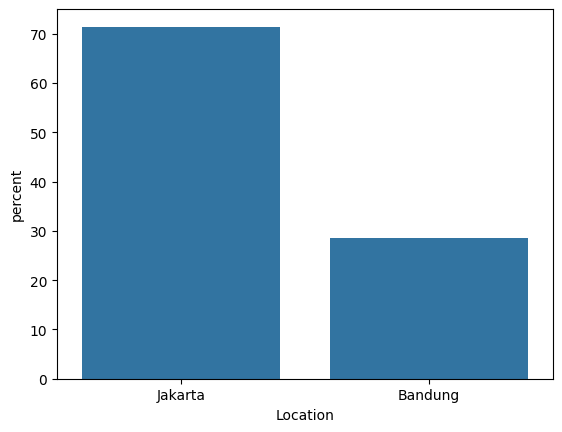

In [10]:
sns.countplot(data=df, x='Location', stat='percent')
plt.show()

It's also not fair to say that people from `Jakarta` has higher change to churn because around 70% are customers from `Jakarta`

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [11]:
# change label of product and app
def preprocess_data(df):
    
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    prod_app_map = {
        "Yes": 1,
        "No": 0,
        "No internet service": 0,
    }
    df['Games Product'] = df['Games Product'].replace(prod_app_map)
    df['Music Product'] = df['Music Product'].replace(prod_app_map)
    df['Education Product'] = df['Education Product'].replace(prod_app_map)
    df['Video Product'] = df['Video Product'].replace(prod_app_map)
    df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

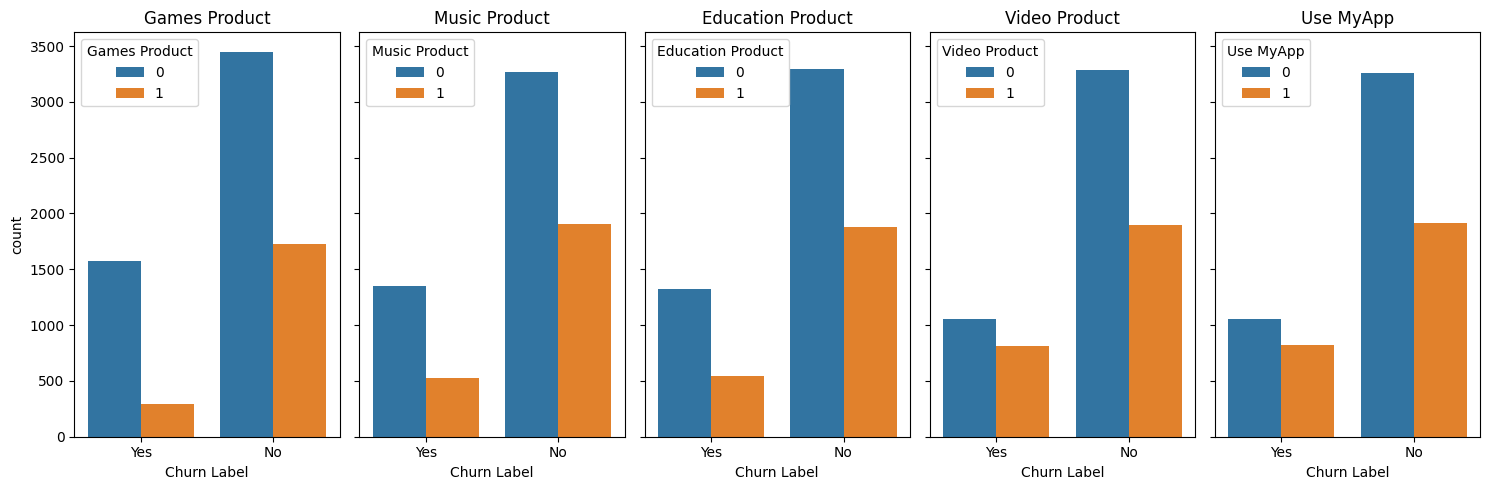

In [12]:
cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(ncols=len(cols), figsize=(15, 5), sharey=True)
for i, c in enumerate(cols):
    sns.countplot(data=df, x='Churn Label', hue=c, ax=ax[i])
    ax[i].set_title(c)
fig.tight_layout()

Churned users use `MyApp` and `Video Product`. Lets dig deeper.

In [13]:
# generate combination
# order: Games Product, Music Product, Education Product, "Video Product", and "Use MyApp"
# ===================================
df["ProductsUsed"] = df.apply(lambda x: str(x["Games Product"]) + str(x["Music Product"]) + str(x["Education Product"]) + str(x["Video Product"]) + str(x["Use MyApp"]), axis=1)
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Internet Service,Churn,Total Purchase,ProductsUsed
0,0,2,Jakarta,Mid End,1,1,0,No,0,0,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,1,1,140.01,11000
1,1,2,Jakarta,High End,0,0,0,No,0,0,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,1,1,183.82,00000
2,2,8,Jakarta,High End,0,0,1,No,1,1,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,1,1,1036.36,00111
3,3,28,Jakarta,High End,0,0,1,Yes,1,1,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1,1,3814.72,00111
4,4,49,Jakarta,High End,0,1,1,No,1,1,Debit,134.810,Yes,106.816666,-6.2,6942.0,1,1,6605.69,01111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,0,0,0,No,0,0,Debit,27.495,No,106.816666,-6.2,6897.8,0,0,1979.64,00000
7039,7039,24,Jakarta,Mid End,1,0,1,Yes,1,1,Digital Wallet,110.240,No,106.816666,-6.2,2782.0,1,0,2645.76,10111
7040,7040,72,Jakarta,High End,0,1,1,No,1,1,Credit,134.160,No,106.816666,-6.2,7228.0,1,0,9659.52,01111
7041,7041,11,Jakarta,Mid End,1,0,0,No,0,0,Pulsa,38.480,No,106.816666,-6.2,3630.9,1,0,423.28,10000


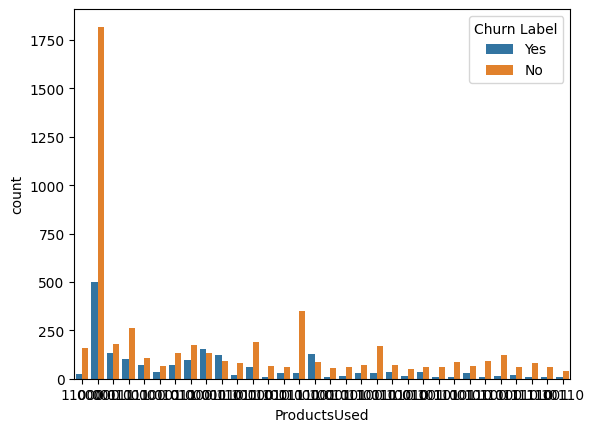

In [14]:
sns.countplot(data=df, x='ProductsUsed', hue="Churn Label")
plt.show()

Wow! This is confusing, just skip this.

## Internet Service
This feature is obtain by checking if `Games Product`, `Music Product`, `Education Product`, `Video Product`, and `Use MyApp` column are all containing `No Internet Service`. This means that the user don't use internet service at all.

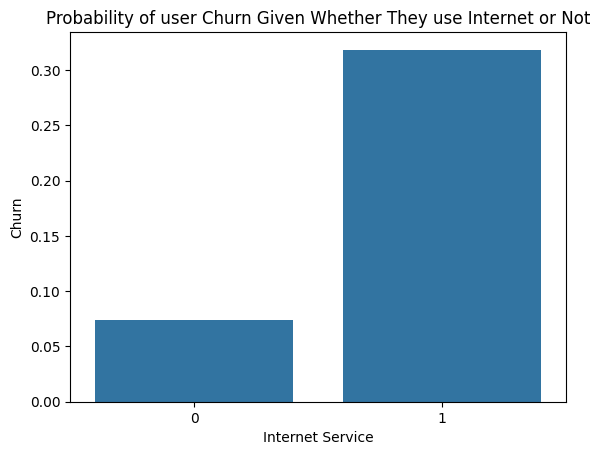

In [15]:
sns.barplot(data=df, x='Internet Service', y="Churn", errorbar=None)
plt.title("Probability of user Churn Given Whether They use Internet or Not")
plt.show()

Users that use internet services has more likely change to churn

## Payment Method

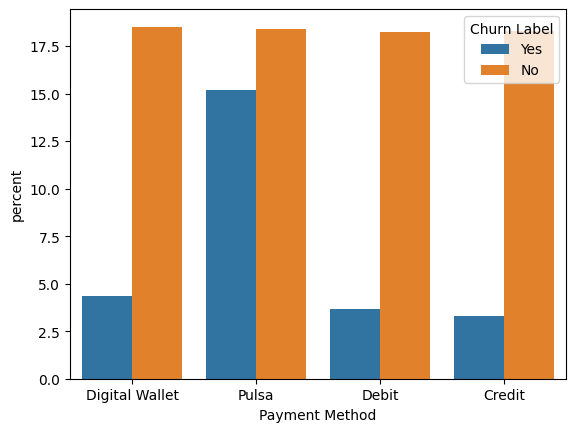

In [16]:
sns.countplot(data=df, x="Payment Method", hue="Churn Label", stat="percent")
plt.show()

In [17]:
churn_payment_method = df.pivot_table(columns="Payment Method", index="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Payment Method,Credit,Debit,Digital Wallet,Pulsa
Churn,,,,
0,0.847569,0.832902,0.808933,0.547146
1,0.152431,0.167098,0.191067,0.452854


If you users buy using pulsa has high change of churn

## Tenure Months

In [18]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


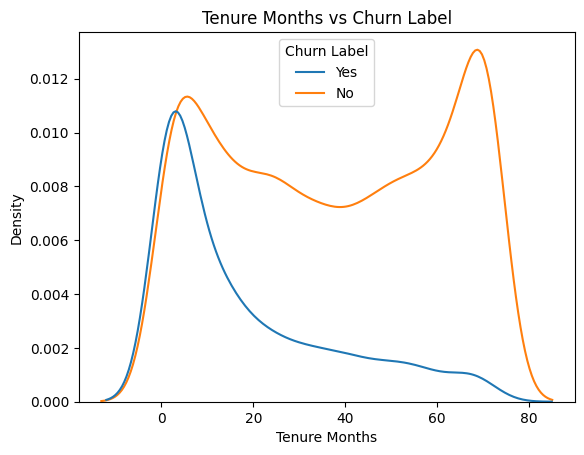

In [19]:
sns.kdeplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

User with low tenure has a high change of churning

## Monthly Purchase

In [20]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

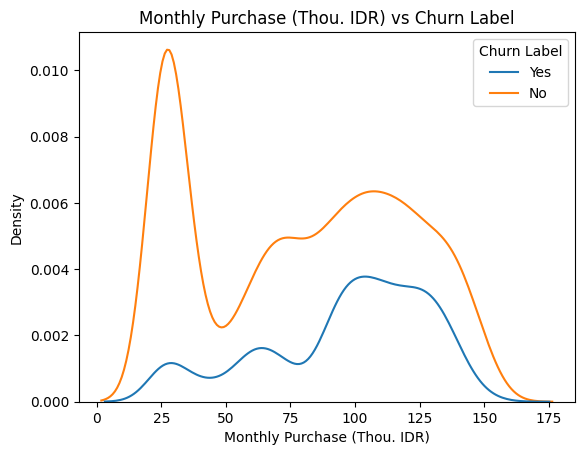

In [21]:
sns.kdeplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 90,000.00 - Rp 140,000.00 a month. The central tendency is there

## CLTV

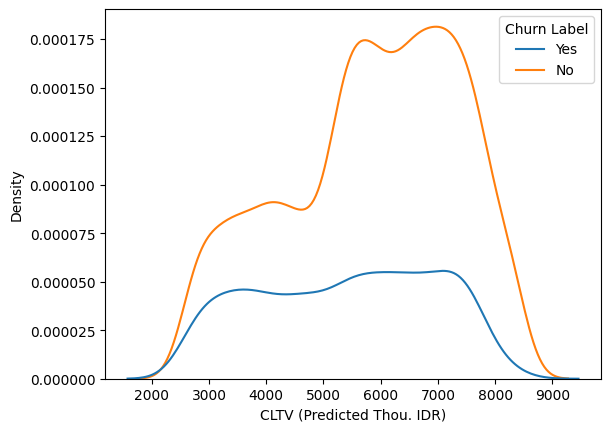

In [22]:
sns.kdeplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature.

## Call Center
Check whether the customer uses the call center service

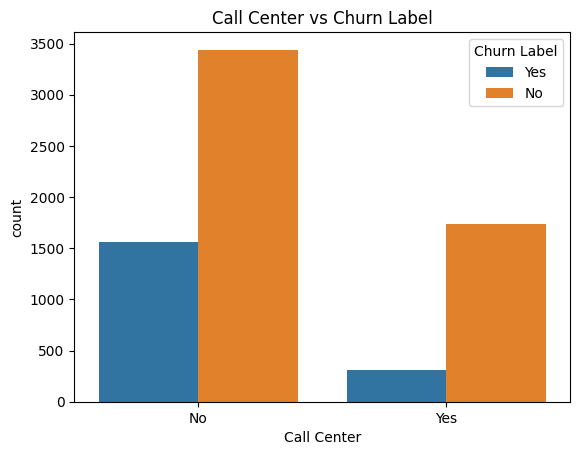

In [23]:
sns.countplot(data=df, x="Call Center", hue="Churn Label")
plt.title("Call Center vs Churn Label")
plt.show()

## Total Purchase

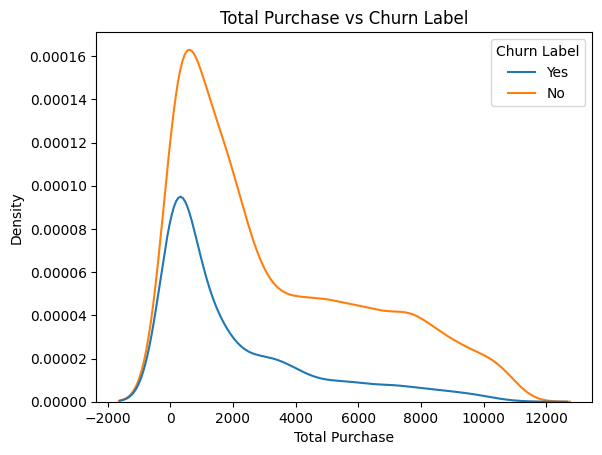

In [24]:
sns.kdeplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

## Correlation Map

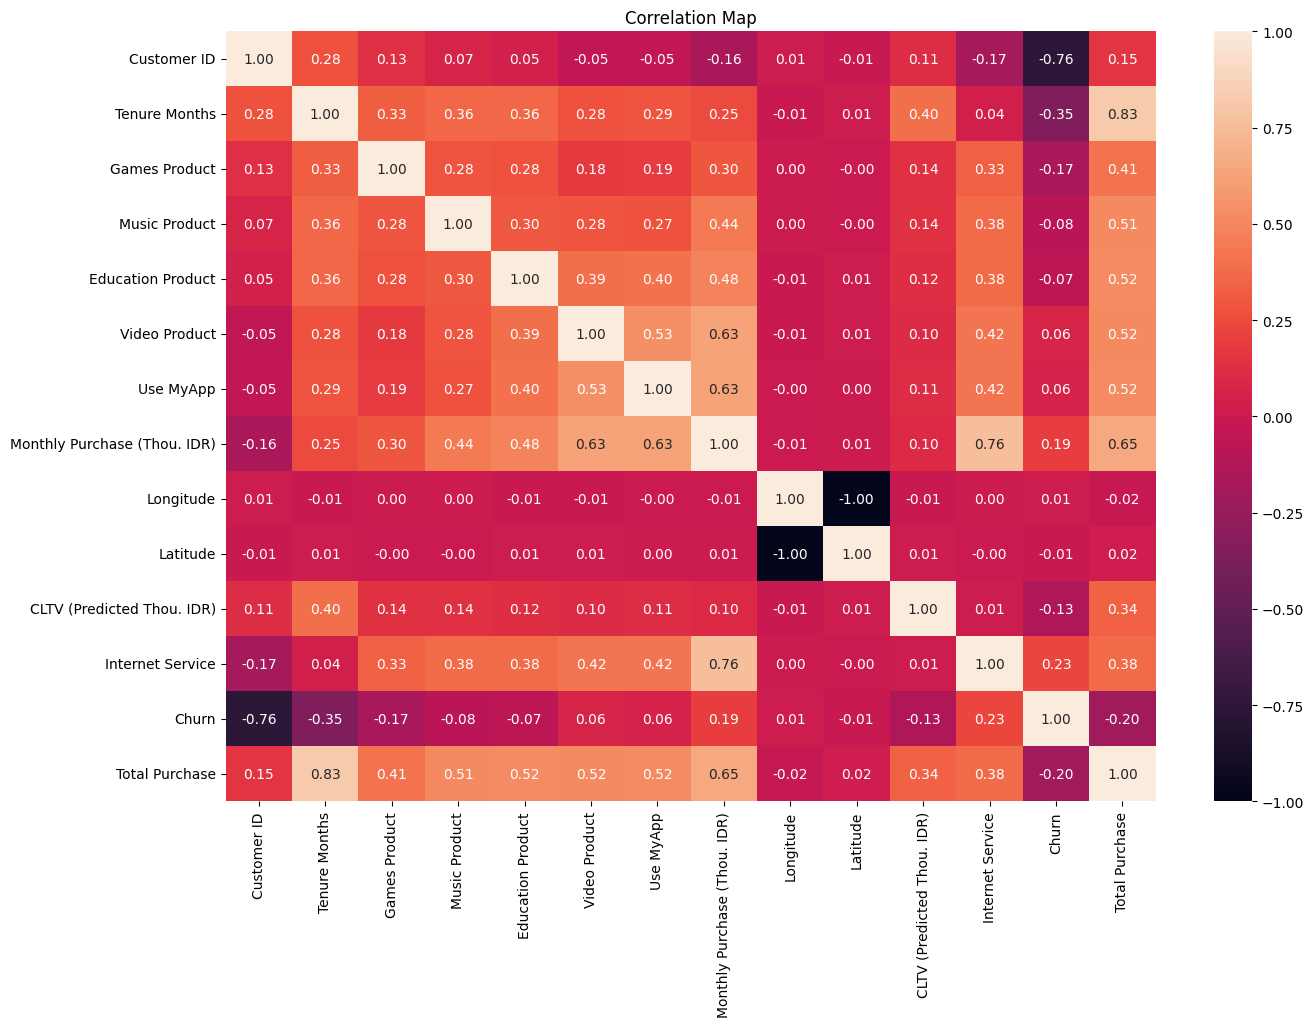

In [26]:
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Data Preparation

In [127]:
# change label of product and app
df = df_ori.copy()
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

# generate new features    
df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']


# replace values
prod_app_map = {
    "Yes": 1,
    "No": 0,
    "No internet service": 0,
}
df['Games Product'] = df['Games Product'].replace(prod_app_map)
df['Music Product'] = df['Music Product'].replace(prod_app_map)
df['Education Product'] = df['Education Product'].replace(prod_app_map)
df['Video Product'] = df['Video Product'].replace(prod_app_map)
df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)
df['Churn'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)
df['Call Center'] = df['Call Center'].replace({"Yes": "1", "No": "0"}).astype(int)

# ordinal encoding
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)

# one hot encoding
df = pd.get_dummies(df, columns=['Payment Method'], dtype=int)

# drop data
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Total Purchase", "Churn Label"])
display(df)

# split data to train and test
X, y = df.drop(columns=["Churn"]), df["Churn"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

# scaling
scaler = StandardScaler()
X_train[["Tenure Months", "Monthly Purchase (Thou. IDR)"]] = scaler.fit_transform(X_train[["Tenure Months", "Monthly Purchase (Thou. IDR)"]])

,Tenure Months,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Monthly Purchase (Thou. IDR),Internet Service,Churn,Payment Method_Credit,Payment Method_Debit,Payment Method_Digital Wallet,Payment Method_Pulsa
0,2,2,1,1,0,0,0,0,70.005,1,1,0,0,1,0
1,2,3,0,0,0,0,0,0,91.910,1,1,0,0,0,1
2,8,3,0,0,1,0,1,1,129.545,1,1,0,0,0,1
3,28,3,0,0,1,1,1,1,136.240,1,1,0,0,0,1
4,49,3,0,1,1,0,1,1,134.810,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,72,1,0,0,0,0,0,0,27.495,0,0,0,1,0,0
7039,24,2,1,0,1,1,1,1,110.240,1,0,0,0,1,0
7040,72,3,0,1,1,0,1,1,134.160,1,0,1,0,0,0
7041,11,2,1,0,0,0,0,0,38.480,1,0,0,0,0,1


In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

X_val[["Tenure Months", "Monthly Purchase (Thou. IDR)"]] = scaler.transform(X_val[["Tenure Months", "Monthly Purchase (Thou. IDR)"]])
pred = model.predict(X_val)

accuracy_score(y_val, pred)

0.7940340909090909